<a href="https://colab.research.google.com/github/macscheffer/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=37.83147459746415, mobile=True), User(purchased=True, time_on_site=297.3760340574865, mobile=True), User(purchased=False, time_on_site=170.27322654263193, mobile=True), User(purchased=False, time_on_site=187.4028623907486, mobile=True), User(purchased=True, time_on_site=78.85190300373333, mobile=True), User(purchased=False, time_on_site=54.52394171181303, mobile=True), User(purchased=False, time_on_site=58.69209574796728, mobile=True), User(purchased=False, time_on_site=7.04429560483984, mobile=True), User(purchased=False, time_on_site=175.00274031166708, mobile=False), User(purchased=True, time_on_site=35.30834596676843, mobile=True)]


In [5]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,37.831475,True
1,True,297.376034,True
2,False,170.273227,True
3,False,187.402862,True
4,True,78.851903,True


In [6]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.339383697685621,5.394155586211019,5.841963075183767,6.726171627185764,6.772109567525894,6.853538565484358,6.973395563092575,7.04429560483984,7.073654370217446,7.176960592900681,...,578.6471133701842,581.6339400063836,582.4490883209,585.3654702081399,591.9387207642812,592.6277843653963,596.3010910445763,596.905457639525,597.4231790667909,599.357239514557
purchased,,,,,,,,,,,,,,,,,,,,,
False,0,1,0,1,1,0,1,1,1,1,...,1,0,0,0,0,0,0,0,1,0
True,1,0,1,0,0,1,0,0,0,0,...,0,1,1,1,1,1,1,1,0,1


In [9]:
pd.crosstab(user_data['purchased'], user_data['mobile'],
            normalize='columns')

mobile,False,True
purchased,,
False,0.704,0.570667
True,0.296,0.429333


In [10]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.745, 124.143]","(124.143, 242.947]","(242.947, 361.75]","(361.75, 480.554]","(480.554, 599.357]"
purchased,,,,,
False,233,209,107,36,19
True,109,145,100,18,24


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.621, 123.202]","(123.202, 241.192]","(241.192, 359.183]","(359.183, 477.174]","(477.174, 595.165]"
purchased,,,,,
False,0.811321,0.832877,0.885572,0.86,0.909091
True,0.188679,0.167123,0.114428,0.14,0.090909


In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.912,0.82
True,0.088,0.18


In [19]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

user_data.head()

df = pd.cut(user_data['time_on_site'], 5)
user_data['bin'] = df

for b in user_data.bin.unique():
  print(df[df.bin == b].describe())

AttributeError: ignored

In [26]:
user_data.head()

,purchased,time_on_site,mobile,bin
0,False,37.831475,True,"(4.745, 124.143]"
1,True,297.376034,True,"(242.947, 361.75]"
2,False,170.273227,True,"(124.143, 242.947]"
3,False,187.402862,True,"(124.143, 242.947]"
4,True,78.851903,True,"(4.745, 124.143]"


In [25]:
series = pd.cut(user_data['time_on_site'], 5)
user_data['bin'] = series

for b in user_data.bin.unique():
  print(user_data[user_data.bin == b].head())

   purchased  time_on_site  mobile               bin
0      False     37.831475    True  (4.745, 124.143]
4       True     78.851903    True  (4.745, 124.143]
5      False     54.523942    True  (4.745, 124.143]
6      False     58.692096    True  (4.745, 124.143]
7      False      7.044296    True  (4.745, 124.143]
    purchased  time_on_site  mobile                bin
1        True    297.376034    True  (242.947, 361.75]
15      False    321.759360   False  (242.947, 361.75]
17       True    298.148660    True  (242.947, 361.75]
21      False    271.358613    True  (242.947, 361.75]
30       True    271.831635    True  (242.947, 361.75]
    purchased  time_on_site  mobile                 bin
2       False    170.273227    True  (124.143, 242.947]
3       False    187.402862    True  (124.143, 242.947]
8       False    175.002740   False  (124.143, 242.947]
10      False    186.550986    True  (124.143, 242.947]
13       True    240.153493    True  (124.143, 242.947]
     purchased  

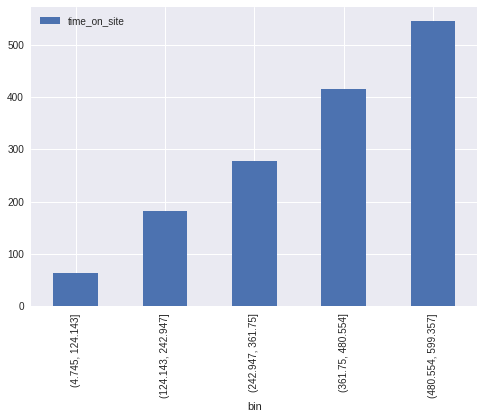

In [30]:
pd.pivot_table(user_data,values='time_on_site',index='bin').plot.bar()
pd.pivot_table(user_data,values='purchased',index='bin').plot.bar()

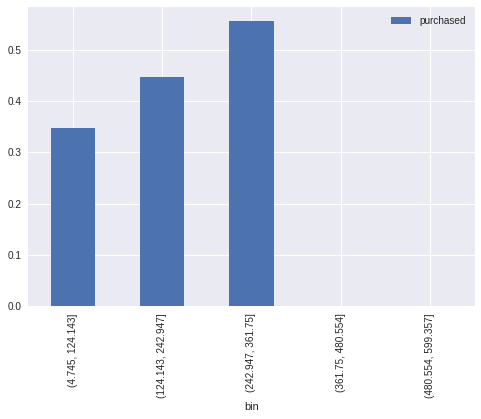

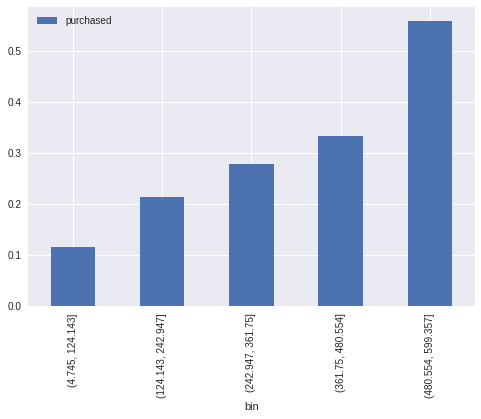

In [33]:
pd.pivot_table(user_data[user_data.mobile == True],values='purchased',index='bin').plot.bar()
pd.pivot_table(user_data[user_data.mobile == False],values='purchased',index='bin').plot.bar()

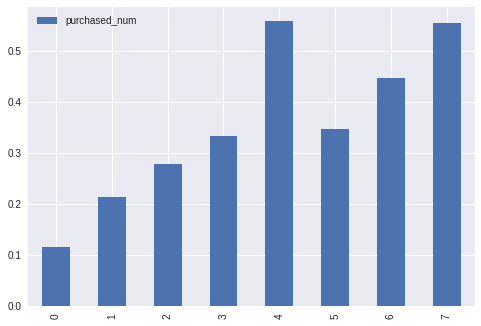

In [42]:
user_data['purchased_num'] = user_data['purchased'] * 1
df = user_data.groupby(['mobile', 'bin'])['purchased_num'].mean()
df = df.reset_index()
df.plot.bar()

In [44]:
# groupby()

grouped_data = user_data.mobile.groupby(user_data.purchased)
len(grouped_data)

2

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself




### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)